In [1]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from lane_detection_util import *

%matplotlib inline
%load_ext autoreload

In [2]:
images = np.array([plt.imread(i) for i in glob.glob('./test_images/*.jpg')] 
                  + [plt.imread(i) for i in glob.glob('./problem_frames/problem_frame*.jpg')])
images_cal = np.array([plt.imread(i) for i in glob.glob('./camera_cal/*.jpg')])
image_size = (images[0].shape[1], images[0].shape[0])

In [3]:
# 1. preapre mask
mask_vertices = np.array([[[182, 720], [500, 466], [782, 464], [1234, 720]]])

# 2. setup threshhold in color channel
color_thresh = [90,255]

# 3. setup threshhold in gray channel
gray_thresh = [200,217] 

# 4. setup source of perspective transform 
src = np.float32([[258, 679], [446, 549], [837, 549], [1045, 679]])

# 5. setup destionation of perspective transform
dst = np.float32([[258, 679], [258, 549], [837, 549], [837, 679]])

# 6. preapre sliding window dimensions
sliding_window = [80,120]

## A. Camera caliberation with parameters ##

In [4]:
dist_matrix, dist_param = camera_cal_parameters(images_cal,image_size)

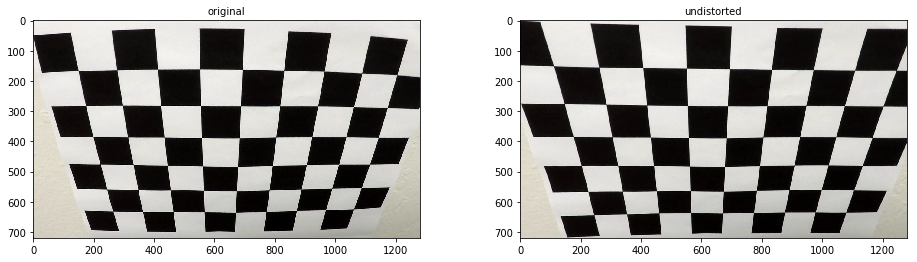

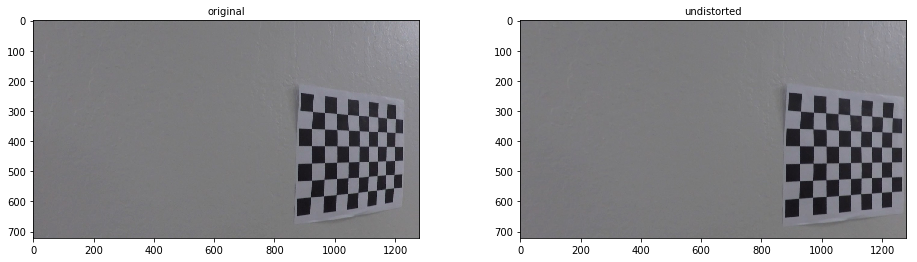

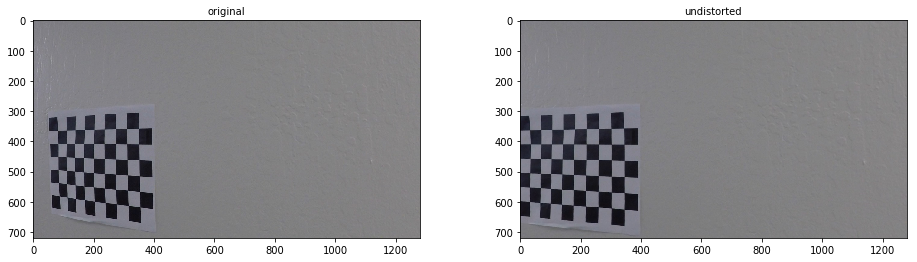

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.imshow(images_cal[7])
ax1.set_title('original', fontsize=10)
ax2.imshow(undistort(images_cal[7], dist_matrix, dist_param))
ax2.set_title('undistorted', fontsize=10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.imshow(images_cal[9])
ax1.set_title('original', fontsize=10)
ax2.imshow(undistort(images_cal[9], dist_matrix, dist_param))
ax2.set_title('undistorted', fontsize=10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.imshow(images_cal[2])
ax1.set_title('original', fontsize=10)
ax2.imshow(undistort(images_cal[2], dist_matrix, dist_param))
ax2.set_title('undistorted', fontsize=10)

plt.show()

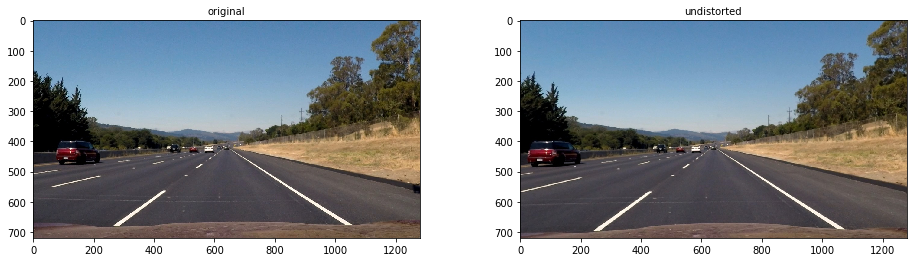

In [6]:
image = images[4]
image_undist = undistort(image, dist_matrix, dist_param)
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.imshow(image)
ax1.set_title('original', fontsize=10)
ax2.imshow(image_undist)
ax2.set_title('undistorted', fontsize=10)
plt.show()

## B. Image thresholding ##

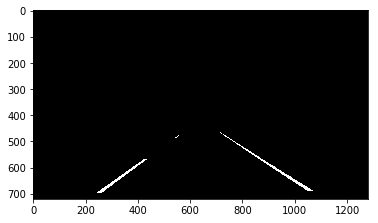

In [7]:
image_binary = preprocess(image_undist, mask_vertices=mask_vertices, color_thresh=color_thresh, gray_thresh=gray_thresh)
plt.imshow(image_binary, cmap='gray')
plt.show()

## C. Perspective Transformation ##

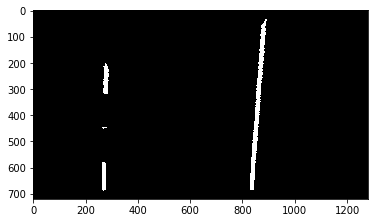

In [8]:
image_binary_bird = perspective_transform(image_binary, src, dst)
plt.imshow(image_binary_bird, cmap='gray')
plt.show()

## D. Detect left and right lane lines ##

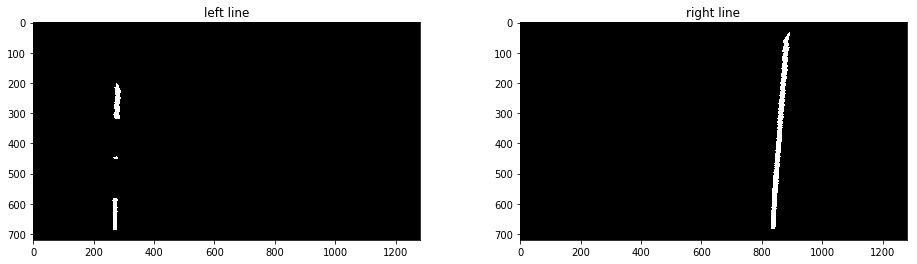

In [9]:
left_lane, right_lane = select_lane_lines(image_binary_bird)
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.imshow(left_lane, cmap='gray')
ax1.set_title('left line')
ax2.imshow(right_lane, cmap='gray')
ax2.set_title('right line')
plt.show()

## E. Fitit positions with a polynomial for lane line ##

In [10]:
left_fit, right_fit = fit_lane_line([left_lane, right_lane])

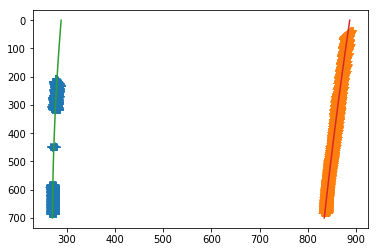

In [11]:
yval = np.linspace(0,700)

left_Y,left_X = np.where(left_lane==1)
left_fitx = left_fit[0]*yval**2 + left_fit[1]*yval + left_fit[2]

right_Y,right_X = np.where(right_lane==1)
right_fitx = right_fit[0]*yval**2 + right_fit[1]*yval + right_fit[2]

plt.plot(left_X, left_Y, '+')
plt.plot(right_X, right_Y, '+')
plt.plot(left_fitx, yval)
plt.plot(right_fitx, yval)
plt.gca().invert_yaxis()

## F. Calculate curvature of the lines ##

In [12]:
radius, deviation = cal_curvature([left_lane, right_lane])

## G. highlight lane in the original image ##

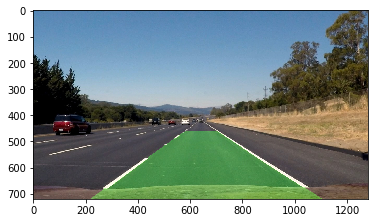

In [13]:
plt.imshow(draw_lane(image, [left_fit, right_fit], src,dst))
plt.show()

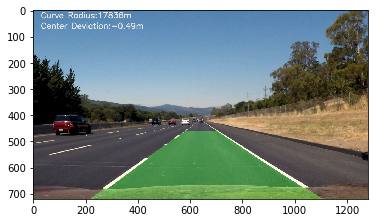

In [14]:
i2 = draw_lane(image, [left_fit, right_fit], src, dst)
plt.imshow(print_info(i2, radius, deviation))
plt.show()

## H. Combine above steps to do pipline ##

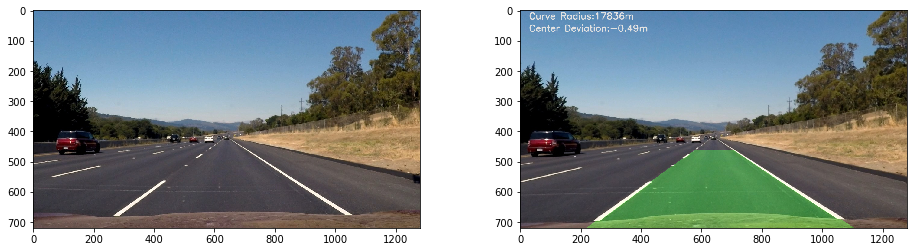

In [15]:
image_highlighted = lane_detection(image, dist_matrix=dist_matrix, dist_param=dist_param, mask_vertices=mask_vertices, 
                                   color_thresh=color_thresh, gray_thresh=gray_thresh, src=src, dst=dst, 
                                   sliding_window=sliding_window)

fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.imshow(image)
ax2.imshow(image_highlighted)
plt.show()

## I. Process lane detecting video ##

In [16]:
def frame_func(image):
    return lane_detection(image, dist_matrix=dist_matrix, dist_param=dist_param,
                          mask_vertices=mask_vertices, color_thresh=color_thresh, gray_thresh=gray_thresh, 
                          src=src, dst=dst, sliding_window=sliding_window)
    
project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
lane_clip = clip1.fl_image(frame_func)
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:39<00:00,  3.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 26s, sys: 5.66 s, total: 3min 32s
Wall time: 5min 42s
